In [9]:
import pandas as pd
import numpy as np

def generate_synthetic_production_data():
    """
    Generates synthetic production history data over a 60-month period.
    
    Assumptions:
      - Reservoir pressure declines linearly from 3000 psia to 1500 psia.
      - Gas compressibility factor (Z) declines linearly from 0.90 to 0.85.
      - The monthly production rate declines exponentially, with an initial rate of 2e6 scf/month
        and a monthly decline rate of 5%.
      - Cumulative production is the running sum of the monthly production rate.
    
    The data are saved as 'synthetic_real_world_production_data.csv' in the current working directory.
    """
    num_months = 60
    start_date = pd.to_datetime("2018-01-01")
    dates = pd.date_range(start_date, periods=num_months, freq='M')
    
    # Define reservoir parameters.
    p_initial = 3000  # Initial pressure in psia.
    p_final = 1500    # Final pressure in psia.
    z_initial = 0.90  # Initial gas compressibility factor.
    z_final = 0.85    # Final gas compressibility factor.
    
    # Generate linearly declining pressure and Z.
    pressures = np.linspace(p_initial, p_final, num_months)
    z_factors = np.linspace(z_initial, z_final, num_months)
    
    # Generate production rate using an exponential decline model.
    Qi = 2e6           # Initial production rate in scf/month.
    decline_rate = 0.05  # Monthly decline rate.
    production_rates = Qi * np.exp(-decline_rate * np.arange(num_months))
    cumulative_production = np.cumsum(production_rates)
    
    # Create a DataFrame with the synthetic production data.
    data = pd.DataFrame({
        'Date': dates,
        'Pressure': pressures,
        'Z': z_factors,
        'ProductionRate': production_rates,
        'CumProduction': cumulative_production
    })
    
    # Save the data to a CSV file.
    output_filename = "synthetic_real_world_production_data.csv"
    data.to_csv(output_filename, index=False)
    print(f"Synthetic production data saved to: {output_filename}")

if __name__ == "__main__":
    generate_synthetic_production_data()


Synthetic production data saved to: synthetic_real_world_production_data.csv


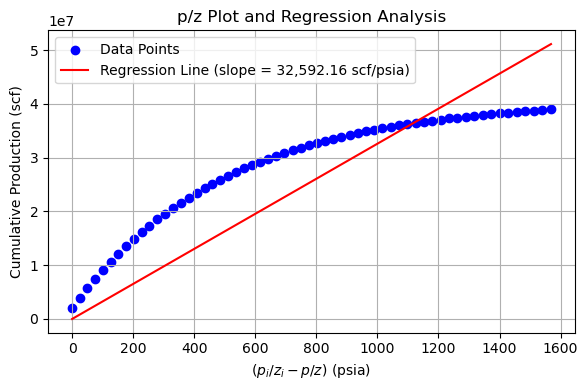

In [12]:
import tkinter as tk
from tkinter import messagebox, filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Global variables to store the production data and matplotlib canvas.
production_data = None
reg_canvas = None

def load_production_data():
    """
    Opens a file dialog for the user to select a CSV file containing production data.
    The CSV file must contain at least the following columns:
      - Date
      - Pressure
      - Z
      - CumProduction
    The function reads the file, parses dates in the Date column, and stores the DataFrame globally.
    """
    global production_data
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    if not file_path:
        return  # User cancelled file selection
    
    try:
        # Read CSV and parse 'Date' as datetime.
        data = pd.read_csv(file_path, parse_dates=['Date'])
        # Check for required columns.
        required_columns = ['Date', 'Pressure', 'Z', 'CumProduction']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            messagebox.showerror("Missing Columns", 
                                 f"The following required columns are missing: {', '.join(missing_columns)}")
            return
        
        production_data = data
        messagebox.showinfo("Data Loaded", f"Production data loaded successfully from:\n{file_path}")
    except Exception as e:
        messagebox.showerror("Load Error", f"Error loading data: {e}")

def perform_regression_analysis():
    """
    Performs a forced-through-the-origin linear regression on the production data using the p/z methodology.
    It uses the first data point as the base condition (p_i and z_i), calculates
      x = (p_i/z_i - p/z)
    for each data record, and then computes the regression slope (in scf/psia). This slope is then
    multiplied by the initial reservoir pressure (psia) to yield an estimate of the OGIP in scf.
    
    The function computes and displays the R² value and plots the data along with the regression line.
    """
    global production_data, reg_canvas
    if production_data is None or production_data.empty:
        messagebox.showerror("No Data", "No production data loaded. Please load a CSV file first.")
        return

    # Confirm that required columns are present.
    required_columns = ['Date', 'Pressure', 'Z', 'CumProduction']
    for col in required_columns:
        if col not in production_data.columns:
            messagebox.showerror("Missing Column", f"Column '{col}' not found in data.")
            return

    # Use the first row as the initial condition.
    try:
        initial_pressure = float(production_data.iloc[0]['Pressure'])
        initial_z = float(production_data.iloc[0]['Z'])
    except Exception as e:
        messagebox.showerror("Data Error", f"Error processing initial values: {e}")
        return

    # Calculate x = (p_i/z_i - p/z) for each row.
    try:
        production_data['x'] = (initial_pressure / initial_z) - (production_data['Pressure'] / production_data['Z'])
    except Exception as e:
        messagebox.showerror("Calculation Error", f"Error calculating x values: {e}")
        return

    # Set y as cumulative production (ensure numeric type).
    try:
        production_data['y'] = pd.to_numeric(production_data['CumProduction'], errors='coerce')
    except Exception as e:
        messagebox.showerror("Conversion Error", f"Error converting cumulative production to numeric: {e}")
        return

    # Remove any rows with NaN values in x or y.
    production_data.dropna(subset=['x', 'y'], inplace=True)

    # Perform forced-through-the-origin regression:
    # slope = sum(x*y) / sum(x^2)
    x = production_data['x'].values
    y = production_data['y'].values
    if np.sum(x**2) == 0:
        messagebox.showerror("Regression Error", "Sum of squares of x is zero; cannot perform regression.")
        return

    slope = np.sum(x * y) / np.sum(x**2)
    # The regression slope is in scf/psia.
    # Multiply by initial reservoir pressure (psia) to convert to scf.
    estimated_ogip_scf = slope * initial_pressure

    # Calculate predicted y values, residuals, and R-squared.
    y_pred = slope * x
    residuals = y - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - ss_res / ss_tot if ss_tot != 0 else 0

    # Display regression results.
    result_msg = (f"Regression Analysis Results:\n"
                  f"Regression Slope: {slope:,.2f} scf/psia\n"
                  f"Estimated OGIP: {estimated_ogip_scf:,.2f} scf\n"
                  f"R-squared: {r_squared:.4f}")
    messagebox.showinfo("Regression Results", result_msg)

    # Plot the scatter plot of x vs. y and the regression line.
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(x, y, color='blue', label='Data Points')
    ax.plot(x, y_pred, color='red', label=f'Regression Line (slope = {slope:,.2f} scf/psia)')
    ax.set_xlabel(r'$(p_i/z_i - p/z)$ (psia)')
    ax.set_ylabel('Cumulative Production (scf)')
    ax.set_title('p/z Plot and Regression Analysis')
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    # Refresh or create the matplotlib canvas in the GUI.
    if reg_canvas is not None:
        reg_canvas.get_tk_widget().destroy()
    reg_canvas = FigureCanvasTkAgg(fig, master=root)
    reg_canvas.draw()
    reg_canvas.get_tk_widget().grid(row=4, column=0, columnspan=2, padx=10, pady=10)

# -----------------------------------------------------------------------------
# Build the Main GUI Window
# -----------------------------------------------------------------------------

root = tk.Tk()
root.title("Reservoir Material Balance Regression Analysis")

# Button to load production data.
button_load = tk.Button(root, text="Load Production Data", command=load_production_data, width=25)
button_load.grid(row=0, column=0, padx=10, pady=10)

# Button to perform regression analysis.
button_regression = tk.Button(root, text="Perform Regression Analysis", command=perform_regression_analysis, width=25)
button_regression.grid(row=0, column=1, padx=10, pady=10)

# Instruction label.
label_instructions = tk.Label(root, text="Ensure the CSV has columns: Date, Pressure, Z, CumProduction",
                              font=("Arial", 10))
label_instructions.grid(row=1, column=0, columnspan=2, padx=10, pady=5)

# Start the GUI event loop.
root.mainloop()
